In [89]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
plt.style.use('seaborn')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.options.display.width = 0

def mpPDF(var,q,pts):
    # Marcenko-Pastur pdf
    # q=T/N
    eMin,eMax=var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2
    eVal=np.linspace(eMin,eMax,pts)
    pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
    pdf=pd.Series(pdf.flatten(),index=eVal.flatten())
    return pdf

def getPCA(matrix):
    # Get eVal,eVec from a Hermitian matrix
    eVal,eVec=np.linalg.eigh(matrix)
    indices=eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal,eVec=eVal[indices],eVec[:,indices]
    eVal=np.diagflat(eVal)
    return eVal,eVec

def fitKDE(obs,bWidth=.25,kernel='gaussian',x=None):
    # Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    if len(obs.shape)==1:
        obs=obs.reshape(-1,1)
    kde=KernelDensity(kernel=kernel,bandwidth=bWidth).fit(obs)
    if x is None:
        x=np.unique(obs).reshape(-1,1)
    if len(x.shape)==1:
        x=x.reshape(-1,1)
    logProb=kde.score_samples(x) # log(density)
    pdf=pd.Series(np.exp(logProb),index=x.flatten())
    return pdf

"""
 FITTING
 THE
 MARCENKO–PASTUR PDF
"""
from scipy.optimize import minimize
def errPDFs(var,eVal,q,bWidth,pts=1000):
    # Fit error
    pdf0=mpPDF(var,q,pts) # theoretical pdf
    pdf1=fitKDE(eVal,bWidth,x=pdf0.index.values) # empirical pdf
    sse=np.sum((pdf1-pdf0)**2)
    return sse

def findMaxEval(eVal,q,bWidth):
    # Find max random eVal by fitting Marcenko’s dist
    out=minimize(lambda *x: errPDFs(*x), .5 , args=(eVal,q,bWidth),
                    bounds=((1E-5,1-1E-5),)
                )
    if out['success']:
        var=out['x'][0]
    else:
        var=1
    eMax=var*(1+(1./q)**.5)**2
    return eMax, var

def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(cov))
    corr=cov/np.outer(std,std)
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error
    return corr

### Import new CC data

In [2]:
result = pd.read_csv('~/Works/practicum_github_repo/Crypto-Data/ml_finance/jenna_data_raw.csv')

In [3]:
result

,date,BTC,ETH,XRP,USDT,BCH,BSV,LTC,EOS,BNB,...,BNT,LOKI,PPT,IOTX,YOU,EDC,XMX,R,FTM,WINK
0,01/01/2019,3843.52,140.82,0.364771,1.020000,164.85,92.14,31.98,2.66,6.08,...,0.650842,0.211717,1.490000,0.007938,0.005066,0.009271,0.000220,0.256234,0.006609,0.000117
1,02/01/2019,3943.41,155.05,0.375243,1.020000,171.83,94.88,33.43,2.89,6.19,...,0.701499,0.205480,1.560000,0.008092,0.005156,0.009184,0.000222,0.246156,0.006963,0.000117
2,03/01/2019,3836.74,149.14,0.360224,1.020000,162.05,88.64,32.03,2.68,5.90,...,0.672790,0.207348,1.480000,0.008041,0.005036,0.008851,0.000215,0.268940,0.006447,0.000117
3,04/01/2019,3857.72,154.58,0.356747,1.020000,161.40,87.65,32.40,2.72,6.07,...,0.689961,0.202332,1.480000,0.007932,0.005029,0.008823,0.000209,0.248345,0.006387,0.000117
4,05/01/2019,3845.19,155.64,0.355275,1.020000,160.40,88.52,34.94,2.70,6.07,...,0.698831,0.209437,1.500000,0.007905,0.004909,0.008697,0.000218,0.257743,0.006037,0.000117
5,06/01/2019,4076.63,157.75,0.368395,1.020000,166.84,90.38,39.30,2.88,6.40,...,0.702547,0.224148,1.570000,0.008349,0.005138,0.008668,0.000227,0.275129,0.005731,0.000117
6,07/01/2019,4025.25,151.70,0.364347,1.010000,161.24,88.78,37.81,2.77,6.29,...,0.684739,0.219533,1.550000,0.008232,0.004975,0.008535,0.000216,0.259324,0.005957,0.000117
7,08/01/2019,4030.85,150.36,0.365315,1.020000,161.91,87.58,39.48,2.80,6.64,...,0.674858,0.218394,1.520000,0.007977,0.004917,0.008689,0.000226,0.258775,0.005847,0.000117
8,09/01/2019,4035.30,150.80,0.370890,1.020000,160.08,87.04,38.99,2.91,6.64,...,0.678107,0.218522,1.530000,0.008140,0.004980,0.008594,0.000219,0.237447,0.005857,0.000161
9,10/01/2019,3678.92,128.63,0.332652,1.020000,134.97,75.92,33.87,2.44,5.92,...,0.584016,0.201598,1.290000,0.006931,0.004820,0.007814,0.000230,0.193589,0.005245,0.000146


In [4]:
result['date'] = pd.to_datetime(result['date'], format='%d/%m/%Y')
# result = result.dropna()
result.date.max() #.set_index('Date')
result = result.set_index('date')
# result = result[(result.index >= '2017-01-01') & ((result.index <= '2017-12-31'))]
result = result.astype(float)

In [5]:
result

,BTC,ETH,XRP,USDT,BCH,BSV,LTC,EOS,BNB,XTZ,...,BNT,LOKI,PPT,IOTX,YOU,EDC,XMX,R,FTM,WINK
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,3843.52,140.82,0.364771,1.020000,164.85,92.14,31.98,2.66,6.08,0.474699,...,0.650842,0.211717,1.490000,0.007938,0.005066,0.009271,0.000220,0.256234,0.006609,0.000117
2019-01-02,3943.41,155.05,0.375243,1.020000,171.83,94.88,33.43,2.89,6.19,0.485319,...,0.701499,0.205480,1.560000,0.008092,0.005156,0.009184,0.000222,0.246156,0.006963,0.000117
2019-01-03,3836.74,149.14,0.360224,1.020000,162.05,88.64,32.03,2.68,5.90,0.482134,...,0.672790,0.207348,1.480000,0.008041,0.005036,0.008851,0.000215,0.268940,0.006447,0.000117
2019-01-04,3857.72,154.58,0.356747,1.020000,161.40,87.65,32.40,2.72,6.07,0.483029,...,0.689961,0.202332,1.480000,0.007932,0.005029,0.008823,0.000209,0.248345,0.006387,0.000117
2019-01-05,3845.19,155.64,0.355275,1.020000,160.40,88.52,34.94,2.70,6.07,0.483224,...,0.698831,0.209437,1.500000,0.007905,0.004909,0.008697,0.000218,0.257743,0.006037,0.000117
2019-01-06,4076.63,157.75,0.368395,1.020000,166.84,90.38,39.30,2.88,6.40,0.484338,...,0.702547,0.224148,1.570000,0.008349,0.005138,0.008668,0.000227,0.275129,0.005731,0.000117
2019-01-07,4025.25,151.70,0.364347,1.010000,161.24,88.78,37.81,2.77,6.29,0.481431,...,0.684739,0.219533,1.550000,0.008232,0.004975,0.008535,0.000216,0.259324,0.005957,0.000117
2019-01-08,4030.85,150.36,0.365315,1.020000,161.91,87.58,39.48,2.80,6.64,0.484993,...,0.674858,0.218394,1.520000,0.007977,0.004917,0.008689,0.000226,0.258775,0.005847,0.000117
2019-01-09,4035.30,150.80,0.370890,1.020000,160.08,87.04,38.99,2.91,6.64,0.495942,...,0.678107,0.218522,1.530000,0.008140,0.004980,0.008594,0.000219,0.237447,0.005857,0.000161


In [8]:
# remove any stable/fiat coins
result = result.loc[:, ~result.columns.isin(['USDT', 'PAX', 'TUSD', 'USDC', 'EURS', 'SAI'])]

In [9]:
returns = result.pct_change().iloc[1:, :].copy()
returns.dropna(axis = 1, thresh=len(returns.index)/2, inplace=True) # Drop stocks with over half the data missing
returns.dropna(axis = 0, thresh=len(returns.columns), inplace=True) # Drop days without data for all stocks

In [10]:
returns

,BTC,ETH,XRP,BCH,BSV,LTC,EOS,BNB,XTZ,LINK,...,BNT,LOKI,PPT,IOTX,YOU,EDC,XMX,R,FTM,WINK
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.025989,0.101051,0.028708,0.042342,0.029737,0.045341,0.086466,0.018092,0.022372,0.057180,...,0.077833,-0.029459,0.046980,0.019400,0.017765,-0.009384,0.009091,-0.039331,0.053563,0.000000
2019-01-03,-0.027050,-0.038117,-0.040025,-0.056917,-0.065767,-0.041879,-0.072664,-0.046850,-0.006563,0.156356,...,-0.040925,0.009091,-0.051282,-0.006303,-0.023274,-0.036259,-0.031532,0.092559,-0.074106,0.000000
2019-01-04,0.005468,0.036476,-0.009652,-0.004011,-0.011169,0.011552,0.014925,0.028814,0.001856,0.194552,...,0.025522,-0.024191,0.000000,-0.013556,-0.001390,-0.003163,-0.027907,-0.076578,-0.009307,0.000000
2019-01-05,-0.003248,0.006857,-0.004126,-0.006196,0.009926,0.078395,-0.007353,0.000000,0.000404,-0.094303,...,0.012856,0.035116,0.013514,-0.003404,-0.023862,-0.014281,0.043062,0.037843,-0.054799,0.000000
2019-01-06,0.060189,0.013557,0.036929,0.040150,0.021012,0.124785,0.066667,0.054366,0.002305,0.002682,...,0.005317,0.070241,0.046667,0.056167,0.046649,-0.003334,0.041284,0.067455,-0.050687,0.000000
2019-01-07,-0.012604,-0.038352,-0.010988,-0.033565,-0.017703,-0.037913,-0.038194,-0.017188,-0.006002,-0.051727,...,-0.025348,-0.020589,-0.012739,-0.014014,-0.031724,-0.015344,-0.048458,-0.057446,0.039435,0.000000
2019-01-08,0.001391,-0.008833,0.002657,0.004155,-0.013517,0.044168,0.010830,0.055644,0.007399,0.126766,...,-0.014430,-0.005188,-0.019355,-0.030977,-0.011658,0.018043,0.046296,-0.002117,-0.018466,0.000000
2019-01-09,0.001104,0.002926,0.015261,-0.011303,-0.006166,-0.012411,0.039286,0.000000,0.022576,-0.052789,...,0.004814,0.000586,0.006579,0.020434,0.012813,-0.010933,-0.030973,-0.082419,0.001710,0.376068
2019-01-10,-0.088316,-0.147016,-0.103098,-0.156859,-0.127757,-0.131316,-0.161512,-0.108434,-0.086923,-0.117472,...,-0.138755,-0.077448,-0.156863,-0.148526,-0.032129,-0.090761,0.050228,-0.184706,-0.104490,-0.093168


In [11]:
# n = 120  #chunk row size
# list_df = [returns[i:i+n] for i in range(0,returns.shape[0],n)]

# [i.shape for i in list_df]


size = 120      # 120 rows in a new data-frame
list_of_dfs = [returns.iloc[i:i+size,:] for i in range(0, len(returns),size-90) if i < len(returns)-90]

[l_d.shape for l_d in list_of_dfs]

[(120, 140),
 (120, 140),
 (120, 140),
 (120, 140),
 (120, 140),
 (120, 140),
 (120, 140),
 (120, 140),
 (120, 140),
 (96, 140)]

In [12]:
training_period = 30
in_sample = returns.iloc[:(returns.shape[0]-training_period), :].copy()

In [13]:
tickers = returns.columns

In [14]:
pd.set_option('use_inf_as_na', True)
in_sample_log_returns = np.log(1+in_sample)
# log_returns.dropna(0, inplace= True)
# log_returns.dropna(1, inplace= True)

In [14]:
# Shapiro-Wilk Test For Gausiannity 
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
# seed the random number generator
seed(1)
# generate univariate observations
# data = 5 * randn(100) + 50
# normality test
for i in range(len(in_sample_log_returns.columns)):
    stat, p = shapiro(in_sample_log_returns.iloc[:, i].values)
    
    # interpret
    alpha = 0.05
    if p > alpha:
        print(i)
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        pass
#         print('Sample does not look Gaussian (reject H0)')

55
Statistics=0.993, p=0.148
Sample looks Gaussian (fail to reject H0)
115
Statistics=0.992, p=0.057
Sample looks Gaussian (fail to reject H0)


In [15]:
# Shapiro-Wilk Test For Gausiannity 
from numpy.random import seed
from numpy.random import randn
from scipy.stats import normaltest
# seed the random number generator
seed(1)
# generate univariate observations
# data = 5 * randn(100) + 50
# normality test
for i in range(len(in_sample_log_returns.columns)):
    stat, p = normaltest(in_sample_log_returns.iloc[:, i].values)
    
    # interpret
    alpha = 0.05
    if p > alpha:
        print(i)
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        pass
#         print('Sample does not look Gaussian (reject H0)')

55
Statistics=5.405, p=0.067
Sample looks Gaussian (fail to reject H0)
115
Statistics=5.023, p=0.081
Sample looks Gaussian (fail to reject H0)


In [15]:
# We will need the standard deviations later:
variances = np.diag(in_sample_log_returns.cov().values)
standard_deviations = np.sqrt(variances) 

In [16]:
corr_mat = in_sample_log_returns.interpolate().corr('spearman')

In [17]:
"""
Start with CCs correlation matrix 
"""
eVal0,eVec0=getPCA(corr_mat)

In [18]:
q = returns.shape[0]/corr_mat.shape[0]

In [19]:
# get bulk of Evalue and Variance
eMax0, var0=findMaxEval(np.diag(eVal0), q, bWidth=.01)
# get nFacts
nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)

In [20]:
nFacts0

2

In [21]:
var0

0.8640324876930231

In [22]:
eMax0

2.263304966492873

In [23]:
D, S = np.linalg.eigh(corr_mat)

print(D[D > eMax0])

[ 3.93342671 54.43300597]


In [24]:
len(D)

140

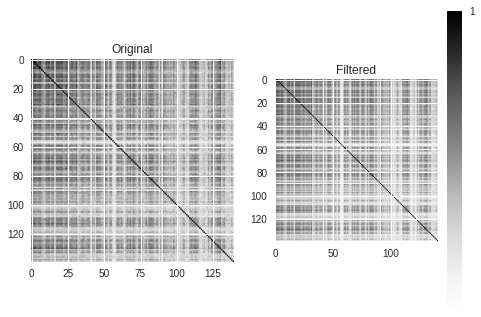

In [25]:
# Filter the eigenvalues out
D[D <= eMax0] = 0

# Reconstruct the matrix
temp =  np.dot(S, np.dot(np.diag(D), np.transpose(S)))

# Set the diagonal entries to 0
np.fill_diagonal(temp, 1)
filtered_matrix = temp

f = plt.figure()
ax = plt.subplot(121)
ax.imshow(corr_mat)
plt.title("Original")
ax = plt.subplot(122)
plt.title("Filtered")
a = ax.imshow(filtered_matrix)
cbar = f.colorbar(a, ticks=[-1, 0, 1])

In [26]:
nFacts0

2

In [27]:
"""
 SNIPPET 2.5 DENOISING
 BY
 CONSTANT RESIDUAL EIGENVALUE
"""
def denoisedCorr(eVal,eVec,nFacts):
    # Remove noise from corr by fixing random eigenvalues
    eVal_=np.diag(eVal).copy()
    eVal_[nFacts:]=eVal_[nFacts:].sum()/float(eVal_.shape[0]-nFacts)
    eVal_=np.diag(eVal_)
    corr1=np.dot(eVec,eVal_).dot(eVec.T)
    corr1=cov2corr(corr1)
    return corr1

# get denoised correlation matrix
corr1=denoisedCorr(eVal0,eVec0,nFacts0)
eVal1,eVec1=getPCA(corr1)

In [28]:
eVal2,eVec2=getPCA(filtered_matrix)

In [29]:
findMaxEval(np.diag(eVec1), q, bWidth=.01)

(2.6194412428706224, 0.99999)

In [30]:
findMaxEval(np.diag(eVec2), q, bWidth=.01)

(2.6194412428706224, 0.99999)

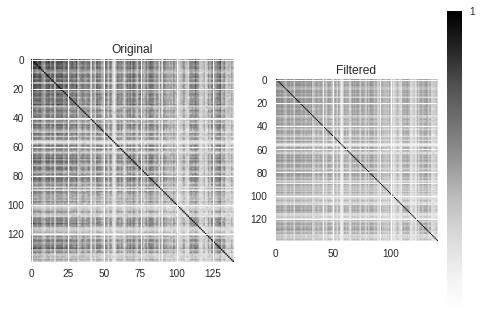

In [31]:
f = plt.figure()
ax = plt.subplot(121)
ax.imshow(corr_mat)
plt.title("Original")
ax = plt.subplot(122)
plt.title("Filtered")
a = ax.imshow(corr1)
cbar = f.colorbar(a, ticks=[-1, 0, 1])

In [32]:
in_sample

,BTC,ETH,XRP,BCH,BSV,LTC,EOS,BNB,XTZ,LINK,...,BNT,LOKI,PPT,IOTX,YOU,EDC,XMX,R,FTM,WINK
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.025989,0.101051,0.028708,0.042342,0.029737,0.045341,0.086466,0.018092,0.022372,0.057180,...,0.077833,-0.029459,0.046980,0.019400,0.017765,-0.009384,0.009091,-0.039331,0.053563,0.000000
2019-01-03,-0.027050,-0.038117,-0.040025,-0.056917,-0.065767,-0.041879,-0.072664,-0.046850,-0.006563,0.156356,...,-0.040925,0.009091,-0.051282,-0.006303,-0.023274,-0.036259,-0.031532,0.092559,-0.074106,0.000000
2019-01-04,0.005468,0.036476,-0.009652,-0.004011,-0.011169,0.011552,0.014925,0.028814,0.001856,0.194552,...,0.025522,-0.024191,0.000000,-0.013556,-0.001390,-0.003163,-0.027907,-0.076578,-0.009307,0.000000
2019-01-05,-0.003248,0.006857,-0.004126,-0.006196,0.009926,0.078395,-0.007353,0.000000,0.000404,-0.094303,...,0.012856,0.035116,0.013514,-0.003404,-0.023862,-0.014281,0.043062,0.037843,-0.054799,0.000000
2019-01-06,0.060189,0.013557,0.036929,0.040150,0.021012,0.124785,0.066667,0.054366,0.002305,0.002682,...,0.005317,0.070241,0.046667,0.056167,0.046649,-0.003334,0.041284,0.067455,-0.050687,0.000000
2019-01-07,-0.012604,-0.038352,-0.010988,-0.033565,-0.017703,-0.037913,-0.038194,-0.017188,-0.006002,-0.051727,...,-0.025348,-0.020589,-0.012739,-0.014014,-0.031724,-0.015344,-0.048458,-0.057446,0.039435,0.000000
2019-01-08,0.001391,-0.008833,0.002657,0.004155,-0.013517,0.044168,0.010830,0.055644,0.007399,0.126766,...,-0.014430,-0.005188,-0.019355,-0.030977,-0.011658,0.018043,0.046296,-0.002117,-0.018466,0.000000
2019-01-09,0.001104,0.002926,0.015261,-0.011303,-0.006166,-0.012411,0.039286,0.000000,0.022576,-0.052789,...,0.004814,0.000586,0.006579,0.020434,0.012813,-0.010933,-0.030973,-0.082419,0.001710,0.376068
2019-01-10,-0.088316,-0.147016,-0.103098,-0.156859,-0.127757,-0.131316,-0.161512,-0.108434,-0.086923,-0.117472,...,-0.138755,-0.077448,-0.156863,-0.148526,-0.032129,-0.090761,0.050228,-0.184706,-0.104490,-0.093168


## After taking out tether portfolio much more reasonable here

      Investment Weight
BTC            0.238648
DOGE           0.146447
XRP            0.097239
HT             0.071190
DASH           0.065731


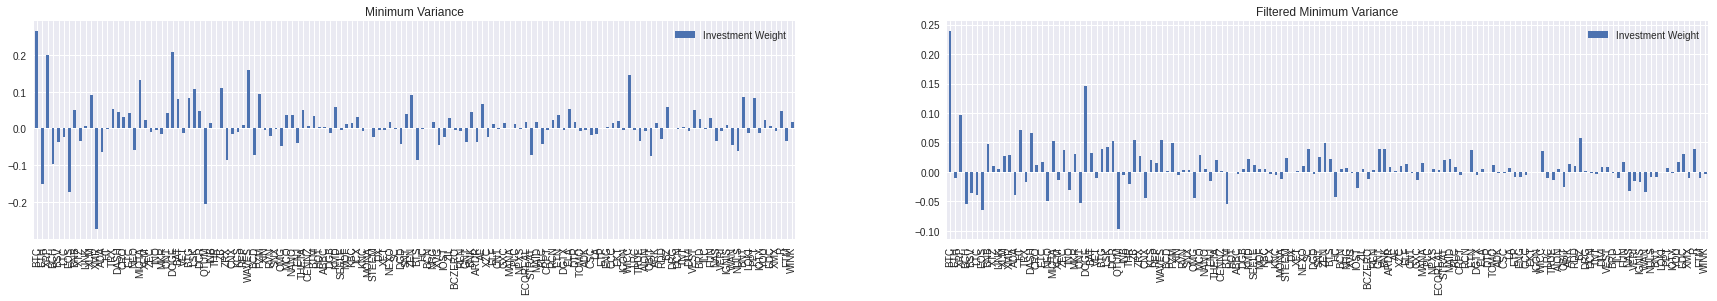

In [33]:
# Reconstruct the filtered covariance matrix
covariance_matrix = in_sample.cov()
inv_cov_mat = np.linalg.pinv(covariance_matrix)

# Construct minimum variance weights
ones = np.ones(len(inv_cov_mat))
inv_dot_ones = np.dot(inv_cov_mat, ones)
min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)

plt.figure(figsize=(30,4))

ax = plt.subplot(121)
min_var_portfolio = pd.DataFrame(data= min_var_weights, 
                                 columns = ['Investment Weight'],
                                 index = tickers)
min_var_portfolio.plot(kind = 'bar', ax = ax)
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.title('Minimum Variance')

# Reconstruct the filtered covariance matrix from the standard deviations and the filtered correlation matrix
filtered_cov = np.dot(np.diag(standard_deviations), 
                           np.dot(filtered_matrix,np.diag(standard_deviations)))

filt_inv_cov = np.linalg.pinv(filtered_cov)

# Construct minimum variance weights
ones = np.ones(len(filt_inv_cov))
inv_dot_ones = np.dot(filt_inv_cov, ones)
filt_min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)
ax = plt.subplot(122)
filt_min_var_portfolio = pd.DataFrame(data= filt_min_var_weights, 
                                 columns = ['Investment Weight'],
                                 index = tickers)
filt_min_var_portfolio.plot(kind = 'bar', ax = ax)
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.title('Filtered Minimum Variance')

print(filt_min_var_portfolio.sort_values(by='Investment Weight', ascending=False).head())

## Interesting as the MVR portfolio doesn't offer much better returns here, possibly because of 2017 inflation?

Text(0.5, 1.0, 'Filtered (Red) vs. Normal (Black)')

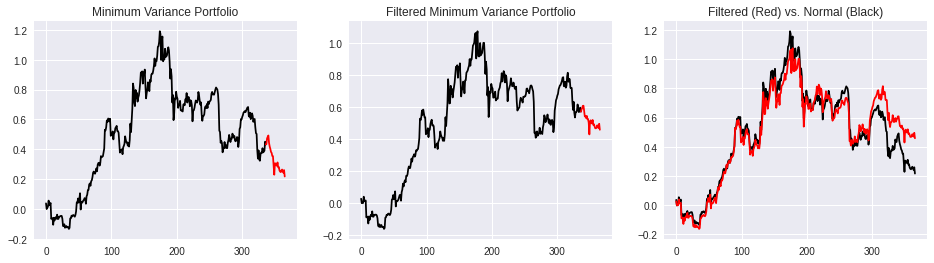

In [35]:
def get_cumulative_returns_over_time(sample, weights):
    # Ignoring short sales
    weights[weights <= 0 ] = 0 
    weights = weights / weights.sum()
    return (((1+sample).cumprod(axis=0))-1).dot(weights)

in_sample_ind = np.arange(0, (returns.shape[0]-training_period+1))
out_sample_ind = np.arange((returns.shape[0]-training_period), returns.shape[0])

cumulative_returns = get_cumulative_returns_over_time(returns, min_var_portfolio).values
cumulative_returns_filt = get_cumulative_returns_over_time(returns, filt_min_var_portfolio).values

f = plt.figure(figsize=(16,4))

ax = plt.subplot(131)
ax.plot(cumulative_returns[in_sample_ind], 'black')
ax.plot(out_sample_ind,cumulative_returns[out_sample_ind], 'r')
plt.title("Minimum Variance Portfolio")

ax = plt.subplot(132)
ax.plot(cumulative_returns_filt[in_sample_ind], 'black')
ax.plot(out_sample_ind,cumulative_returns_filt[out_sample_ind], 'r')
plt.title("Filtered Minimum Variance Portfolio")

ax = plt.subplot(133)
ax.plot(cumulative_returns, 'black')
ax.plot(cumulative_returns_filt, 'r')
plt.title("Filtered (Red) vs. Normal (Black)")

In [36]:
print(filt_min_var_portfolio.sort_values(by='Investment Weight', ascending=False).head())

      Investment Weight
BTC            0.238648
DOGE           0.146447
XRP            0.097239
HT             0.071190
DASH           0.065731


### Sliding window Min Var Portfolios

In [37]:
def create_filtered_portfolios(returns, test_period):

    # test_period = 30
    in_sample = returns.iloc[:(returns.shape[0]-test_period), :].copy()
    in_sample_log_returns = np.log(1+in_sample)

    # We will need the standard deviations later:
    variances = np.diag(in_sample_log_returns.cov().values)
    standard_deviations = np.sqrt(variances) 
    corr_mat = in_sample_log_returns.interpolate().corr('spearman')

    eVal0,eVec0=getPCA(corr_mat)
    q = returns.shape[0]/corr_mat.shape[0]

    # get bulk of Evalue and Variance
    eMax0, var0=findMaxEval(np.diag(eVal0), q, bWidth=.01)
    # get nFacts
    nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)


    D, S = np.linalg.eigh(corr_mat)
    print(D[D > eMax0])
    # Filter the eigenvalues out
    D[D <= eMax0] = 0
    # Reconstruct the matrix
    temp =  np.dot(S, np.dot(np.diag(D), np.transpose(S)))
    # Set the diagonal entries to 0
    np.fill_diagonal(temp, 1)
    filtered_matrix = temp



    # Reconstruct the filtered covariance matrix
    covariance_matrix = in_sample.cov()
    inv_cov_mat = np.linalg.pinv(covariance_matrix)

    # Construct minimum variance weights
    ones = np.ones(len(inv_cov_mat))
    inv_dot_ones = np.dot(inv_cov_mat, ones)
    min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)

    min_var_portfolio = pd.DataFrame(data= min_var_weights, 
                                    columns = ['Investment Weight'],
                                    index = tickers)
    # Reconstruct the filtered covariance matrix from the standard deviations and the filtered correlation matrix
    filtered_cov = np.dot(np.diag(standard_deviations), 
                            np.dot(filtered_matrix,np.diag(standard_deviations)))
    filt_inv_cov = np.linalg.pinv(filtered_cov)

    # Construct minimum variance weights
    ones = np.ones(len(filt_inv_cov))
    inv_dot_ones = np.dot(filt_inv_cov, ones)
    filt_min_var_weights = inv_dot_ones/ np.dot( inv_dot_ones , ones)
    filt_min_var_portfolio = pd.DataFrame(data= filt_min_var_weights, 
                                    columns = ['Investment Weight'],
                                    index = tickers)

    def get_cumulative_returns_over_time(sample, weights):
        # Ignoring short sales
        weights[weights <= 0 ] = 0 
        weights = weights / weights.sum()
        return (((1+sample).cumprod(axis=0))-1).dot(weights)

    in_sample_ind = np.arange(0, (returns.shape[0]-test_period+1))
    out_sample_ind = np.arange((returns.shape[0]-test_period), returns.shape[0])

    cumulative_returns = get_cumulative_returns_over_time(returns, min_var_portfolio).values
    cumulative_returns_filt = get_cumulative_returns_over_time(returns, filt_min_var_portfolio).values
    
    f = plt.figure(figsize=(16,4))

    ax = plt.subplot(131)
    ax.plot(cumulative_returns[in_sample_ind], 'black')
    ax.plot(out_sample_ind,cumulative_returns[out_sample_ind], 'r')
    plt.title("Minimum Variance Portfolio")

    ax = plt.subplot(132)
    ax.plot(cumulative_returns_filt[in_sample_ind], 'black')
    ax.plot(out_sample_ind,cumulative_returns_filt[out_sample_ind], 'r')
    plt.title("Filtered Minimum Variance Portfolio")

    ax = plt.subplot(133)
    ax.plot(cumulative_returns, 'black')
    ax.plot(cumulative_returns_filt, 'r')
    plt.title("Filtered (Red) vs. Normal (Black)")

    return None

[ 3.54130785 54.98701109]
[ 1.76482343  1.83000001  1.94501451  1.95917585  2.05062797  2.15125782
  2.20647357  2.26263477  2.58227024  5.56960911 59.53068757]
[ 1.76341334  1.78570526  1.8851457   1.90168938  1.94448431  2.03241327
  2.05033531  2.12846717  2.16046524  2.34211961  2.4975684   4.85403263
 56.35072289]
[54.8229879]


[None, None, None, None]

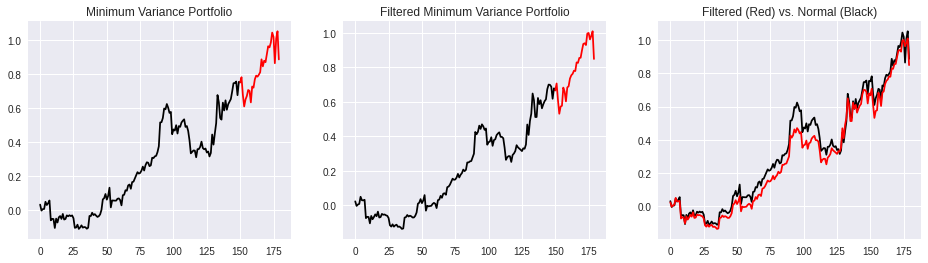

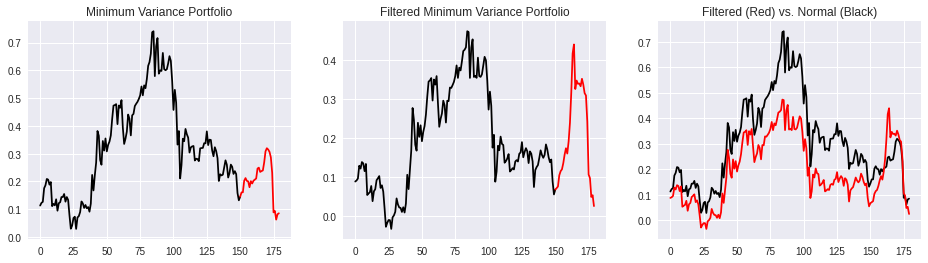

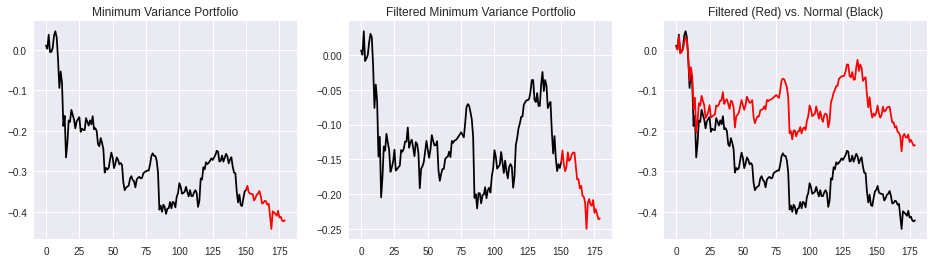

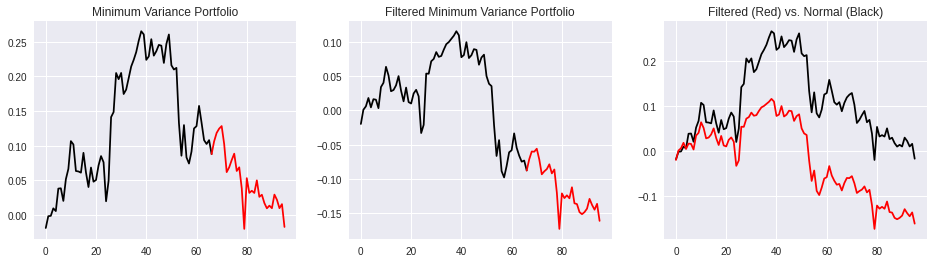

In [38]:
size = 180      # 120 rows in a new data-frame
list_of_dfs = [returns.iloc[i:i+size,:] for i in range(0, len(returns),size-90) if i < len(returns)-90]

[l_d.shape for l_d in list_of_dfs]
[create_filtered_portfolios(l_d, 30) for l_d in list_of_dfs]

[51.82886398]
[ 5.36624154 58.00376514]
[ 6.42358769 58.25018096]
[54.8229879]


[None, None, None, None]

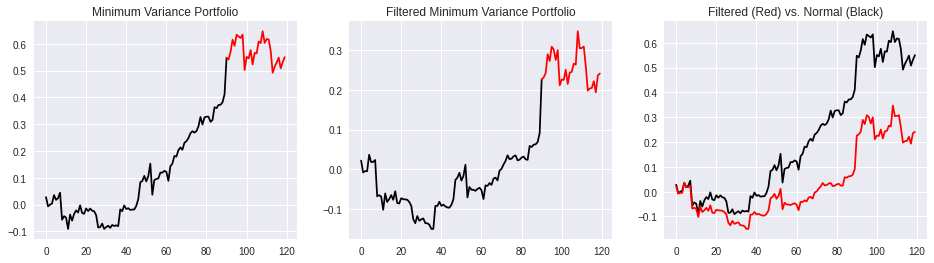

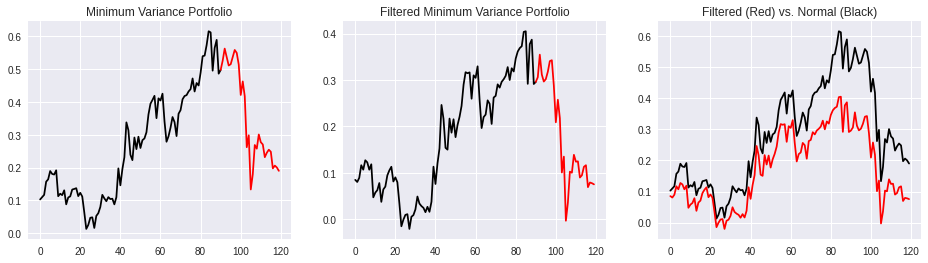

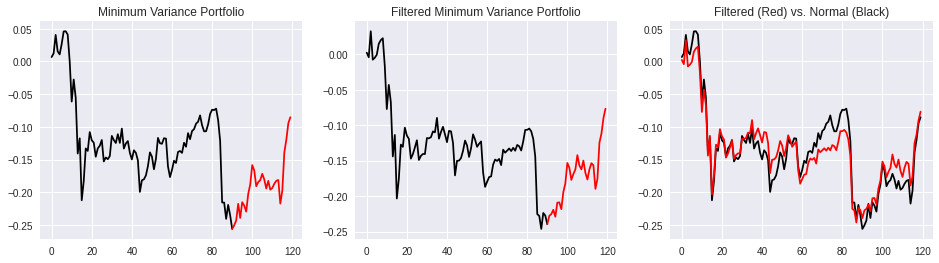

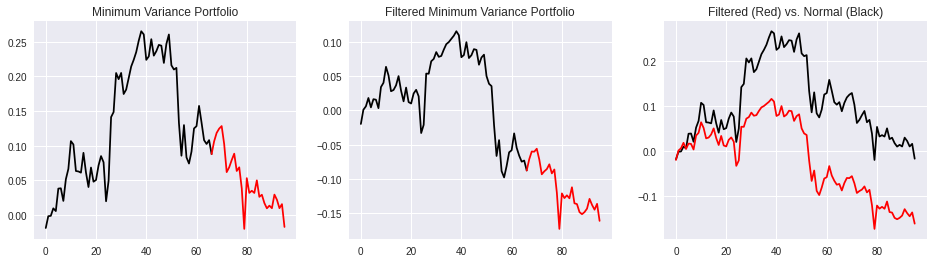

In [39]:
size = 120      # 120 rows in a new data-frame
list_of_dfs = [returns.iloc[i:i+size,:] for i in range(0, len(returns),size-30) if i < len(returns)-30]

[l_d.shape for l_d in list_of_dfs]
[create_filtered_portfolios(l_d, 30) for l_d in list_of_dfs]

### Ward Method

In [34]:
## First step is to calculate the distance matrix from the filtered matrix 
## next get condensed matrix from distance matrix (i.e the upper traingular of distance matrix)
def compute_distance_matrix(corr_mat, tickers):
    """
    Computes Correlation Matrix from the CC matrix, 
    and computes distance matrix from correlation matrix
    
    returns:
        - Distance matrix dataframe
    """
    
    ## Distance formula d(i,j) = 1-p(i,j)^2
    dist_mat = corr_mat
    for i in range(len(corr_mat)):
        for j in range(len(corr_mat)):
            dist_mat[i][j] = 1 - (corr_mat[i][j]**2)
    

    # add CC names
    df_dist_mat = pd.DataFrame(dist_mat, columns=tickers, index=tickers)
    
    return df_dist_mat

dist_mat_df = compute_distance_matrix(filtered_matrix.copy(), tickers)
# np.fill_diagonal(dist_mat_df.values, 0)
# import scipy.spatial.distance as ssd
# aa = ssd.squareform(dist_mat_df.values)

In [35]:
aa = dist_mat_df.copy()

In [36]:
aa = np.nan_to_num(aa.values)

In [37]:
aa

array([[0.        , 0.38367339, 0.50721728, ..., 0.89137024, 0.84252892,
        0.92894275],
       [0.38367339, 0.        , 0.40669344, ..., 0.88379286, 0.76107246,
        0.92048614],
       [0.50721728, 0.40669344, 0.        , ..., 0.89800782, 0.76057614,
        0.92887864],
       ...,
       [0.89137024, 0.88379286, 0.89800782, ..., 0.        , 0.95957293,
        0.98625745],
       [0.84252892, 0.76107246, 0.76057614, ..., 0.95957293, 0.        ,
        0.97066098],
       [0.92894275, 0.92048614, 0.92887864, ..., 0.98625745, 0.97066098,
        0.        ]])

In [38]:
import scipy.spatial.distance as ssd
cond = ssd.squareform(aa, checks=False)

In [39]:
cond.shape

(9730,)

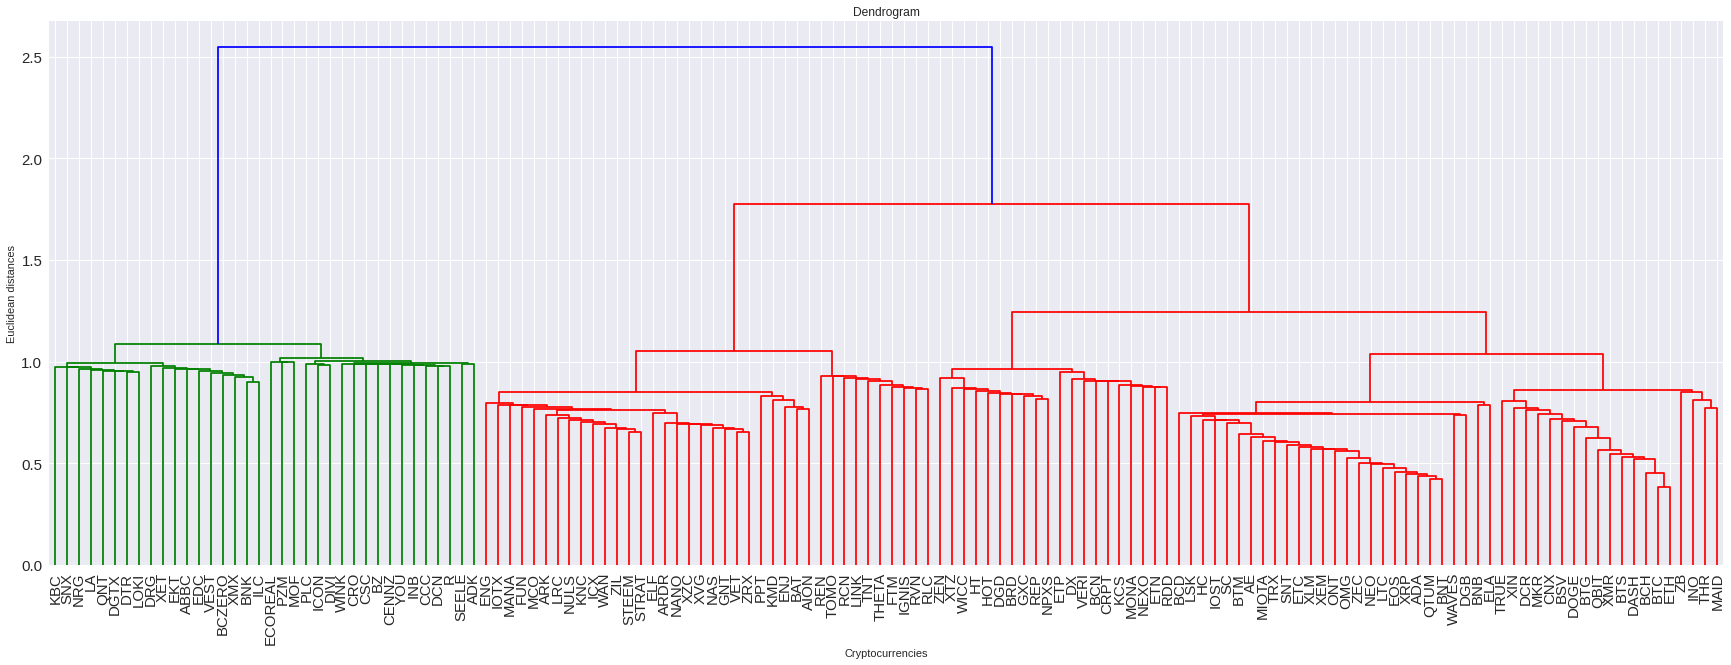

In [40]:
# Lets create a dendrogram variable linkage is actually the algorithm #itself of hierarchical clustering and
# then in linkage we have to #specify on which data we apply and engage. 
# This is X dataset
import scipy.cluster.hierarchy as sch 
plt.figure(figsize=(30,10))

dendrogram = sch.dendrogram(sch.linkage(cond, method  = "ward"), labels = tickers)

plt.tick_params(axis='both', which='major', labelsize=15)
plt.title('Dendrogram')
plt.xlabel('Cryptocurrencies')
plt.ylabel('Euclidean distances')
plt.savefig('dendrogram.jpg')
plt.show()

In [41]:
from sklearn.cluster import AgglomerativeClustering 
hc = AgglomerativeClustering(n_clusters = 8, affinity = 'euclidean', linkage ='ward')

In [42]:
np.reshape(cond, (-1, 1))

array([[0.38367339],
       [0.50721728],
       [0.45573743],
       ...,
       [0.95957293],
       [0.98625745],
       [0.97066098]])

In [43]:
y_hc=hc.fit_predict(np.reshape(cond, (-1, 1)))

In [44]:
class_labels = ssd.squareform(y_hc, checks=False)[[0]]

In [45]:
some_list = list(zip(list(class_labels)[0], list(tickers)))

In [46]:
clusters_ward = pd.DataFrame(some_list, columns=['class_number', 'tickers'])


In [63]:
unstacked = clusters_ward.groupby(['class_number', 'tickers'])['tickers'].sum().unstack()

In [68]:
unstacked_2 = pd.concat([s.dropna().reset_index(drop=True) for i,s in unstacked.iterrows()], 1).T


In [72]:
unstacked_2.replace(np.nan, '', regex=True, inplace=True)

In [74]:
# unstacked_2.to_latex()

In [48]:
hd = dict()
for k in range(len(unstacked)):
    print(f'{k}: {unstacked.iloc[k].dropna().values}\n')


0: ['ADA' 'BCH' 'BNT' 'BSV' 'BTC' 'BTG' 'BTM' 'BTS' 'CNX' 'DASH' 'DOGE' 'EOS'
 'ETC' 'ETH' 'LTC' 'MAID' 'NEO' 'OMG' 'ONT' 'QBIT' 'QTUM' 'THR' 'XEM'
 'XLM' 'XMR' 'XRP' 'ZEC']

1: ['AE' 'BCD' 'BNB' 'DCR' 'DGB' 'ELA' 'HC' 'INO' 'IOST' 'LSK' 'MIOTA' 'MKR'
 'NAS' 'SC' 'SNT' 'TRUE' 'TRX' 'VET' 'WAVES' 'XIN' 'XZC' 'ZB' 'ZRX']

2: ['ADK' 'BZ' 'CCC' 'CENNZ' 'CRO' 'CSC' 'DIVI' 'ENJ' 'PLC' 'RCN' 'REN'
 'SEELE' 'THETA' 'WINK' 'YOU']

3: ['ABBC' 'ARK' 'BAT' 'DGTX' 'DTR' 'EDC' 'EKT' 'ENG' 'ETP' 'FTM' 'IGNIS'
 'KMD' 'KNC' 'LA' 'LOKI' 'NRG' 'QNT' 'STRAT' 'TOMO' 'VEST' 'XET' 'ZEN']

4: ['ARDR' 'BCN' 'BNK' 'BRD' 'CRPT' 'ETN' 'GNT' 'HT' 'ICX' 'ILC' 'KCS' 'MONA'
 'NANO' 'NEXO' 'NPXS' 'RDD' 'REP' 'WICC' 'XTZ' 'XVG']

5: ['ECOREAL' 'MOF' 'PZM']

6: ['AION' 'DCN' 'DRG' 'ICON' 'INB' 'KBC' 'LINK' 'PPT' 'R' 'RLC' 'RVN' 'SNX'
 'TNT']

7: ['BCZERO' 'DGD' 'DX' 'ELF' 'FUN' 'GXC' 'HOT' 'IOTX' 'LRC' 'MANA' 'MCO'
 'NULS' 'STEEM' 'VERI' 'WAN' 'XMX' 'ZIL']



In [53]:
filt_min_var_portfolio[filt_min_var_portfolio>0].dropna()

,Investment Weight
BTC,0.238648
XRP,0.097239
BNB,0.047788
XTZ,0.010149
LINK,0.005698
XLM,0.026486
XMR,0.028560
HT,0.071190
DASH,0.065731
CRO,0.011312


In [92]:
def ward_clustering(returns, test_period, tickers, **kwargs):
    
    # test_period = 30
    in_sample = returns.iloc[:(returns.shape[0]-test_period), :].copy()
    in_sample_log_returns = np.log(1+in_sample)

    # We will need the standard deviations later:
    variances = np.diag(in_sample_log_returns.cov().values)
    standard_deviations = np.sqrt(variances) 
    corr_mat = in_sample_log_returns.interpolate().corr('spearman')

    eVal0,eVec0=getPCA(corr_mat)
    q = returns.shape[0]/corr_mat.shape[0]

    # get bulk of Evalue and Variance
    eMax0, var0=findMaxEval(np.diag(eVal0), q, bWidth=.01)
    # get nFacts
    nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)


    D, S = np.linalg.eigh(corr_mat)
    print(D[D > eMax0])
    # Filter the eigenvalues out
    D[D <= eMax0] = 0
    # Reconstruct the matrix
    temp =  np.dot(S, np.dot(np.diag(D), np.transpose(S)))
    # Set the diagonal entries to 0
    np.fill_diagonal(temp, 1)
    filtered_matrix = temp


    # compute distance matrix
    dist_mat_df = compute_distance_matrix(filtered_matrix.copy(), tickers)

    aa = dist_mat_df.copy()
    # fill nan with 0s
    aa = np.nan_to_num(aa.values)

    import scipy.spatial.distance as ssd
    # convert to condensed matrix
    cond = ssd.squareform(aa, checks=False)

    # Lets create a dendrogram variable linkage is actually the algorithm #itself of hierarchical clustering and
    # then in linkage we have to #specify on which data we apply and engage. 
    import scipy.cluster.hierarchy as sch 
    plt.figure(figsize=(30,10))

    # Create dendrogram
    dendrogram = sch.dendrogram(sch.linkage(cond, method  = "ward"), labels = tickers)

    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.title('Dendrogram')
    plt.xlabel('Cryptocurrencies')
    plt.ylabel('Euclidean distances')
    plt.savefig(f'dendrogram_{dendo}.jpg')


    from sklearn.cluster import AgglomerativeClustering 
    # apply fixed number of clusters and fit cluster
    hc = AgglomerativeClustering(n_clusters = 8, affinity = 'euclidean', linkage ='ward')
    y_hc=hc.fit_predict(np.reshape(cond, (-1, 1)))

    class_labels = ssd.squareform(y_hc, checks=False)[[0]]
    some_list = list(zip(list(class_labels)[0], list(tickers)))
    clusters_ward = pd.DataFrame(some_list, columns=['class_number', 'tickers'])
    unstacked = clusters_ward.groupby(['class_number', 'tickers'])['tickers'].sum().unstack()
    unstacked_2 = pd.concat([s.dropna().reset_index(drop=True) for i,s in unstacked.iterrows()], 1).T
    unstacked_2.replace(np.nan, '', regex=True, inplace=True)
    display(unstacked_2)


In [99]:
result[['BTC', 'ETH', 'XRP', 'XMR']].log.plot()

AttributeError: 'DataFrame' object has no attribute 'log'

[51.82886398]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38
0,BCZERO,BNK,BTC,CRPT,DCN,DGTX,HOT,IGNIS,KBC,KCS,LA,LINK,LOKI,NPXS,RCN,RVN,SEELE,SNX,THETA,WAVES,WINK,XTZ,YOU,,,,,,,,,,,,,,,,
1,ARK,BAT,HT,INO,LRC,MCO,RDD,REN,REP,STEEM,TRUE,WICC,ZB,ZEN,,,,,,,,,,,,,,,,,,,,,,,,,
2,AE,AION,ARDR,BCD,BCN,BRD,BTM,DCR,DGB,DGD,DOGE,ELA,ELF,ENG,FUN,GXC,HC,IOST,IOTX,KMD,KNC,MAID,MANA,MKR,NANO,NAS,NULS,ONT,PPT,QBIT,SC,SNT,STRAT,TRX,WAN,XIN,XVG,XZC,ZIL
3,ABBC,DIVI,DRG,ECOREAL,PZM,R,THR,VEST,XET,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,ADK,CENNZ,CRO,CSC,DTR,DX,EDC,EKT,ICON,MOF,QNT,TOMO,XMX,,,,,,,,,,,,,,,,,,,,,,,,,,
5,BNB,BZ,CCC,ENJ,ETN,ETP,FTM,NEXO,RLC,TNT,VERI,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,ADA,BCH,BNT,BSV,BTG,BTS,CNX,DASH,EOS,ETC,ETH,GNT,ICX,LSK,LTC,MIOTA,MONA,NEO,OMG,QTUM,VET,XEM,XLM,XMR,XRP,ZEC,ZRX,,,,,,,,,,,,
7,ILC,INB,NRG,PLC,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


[ 5.36624154 58.00376514]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,ADK,BTC,BZ,CENNZ,DCN,DGTX,DIVI,DTR,ECOREAL,EDC,ENG,FTM,GXC,HT,ICON,KNC,LINK,PLC,PPT,REN,RLC,RVN,SNX,THETA,TOMO,WINK,,,,
1,ADA,BCH,BNT,BTG,BTS,DASH,EOS,ETC,ETH,QTUM,SNT,THR,VEST,XEM,XLM,XMR,XRP,,,,,,,,,,,,,
2,ARK,BAT,BNB,BNK,CCC,DGD,DRG,EKT,ETP,HOT,IGNIS,INO,IOTX,KMD,LOKI,MANA,MCO,MONA,NAS,NRG,NULS,R,RCN,TNT,WAN,XET,XMX,YOU,ZEN,ZIL
3,AE,BCD,BTM,CNX,DCR,DOGE,LSK,LTC,MKR,NEO,OMG,ONT,QBIT,SC,TRX,ZEC,,,,,,,,,,,,,,
4,CRO,CSC,ENJ,INB,KBC,MOF,PZM,QNT,SEELE,,,,,,,,,,,,,,,,,,,,,
5,ABBC,AION,BCZERO,ELA,HC,ILC,NANO,STEEM,VERI,WICC,XZC,,,,,,,,,,,,,,,,,,,
6,ARDR,BCN,BSV,CRPT,DGB,GNT,ICX,IOST,LA,MAID,MIOTA,NPXS,RDD,REP,VET,WAVES,XIN,XTZ,XVG,ZRX,,,,,,,,,,
7,BRD,DX,ELF,ETN,FUN,KCS,LRC,NEXO,STRAT,TRUE,ZB,,,,,,,,,,,,,,,,,,,


[ 6.42358769 58.25018096]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,AE,BNB,BSV,BTC,BTG,BTM,CNX,DGB,DGTX,DX,EDC,EOS,ETC,HC,IOST,KCS,MKR,OMG,ONT,SC,SNT,TRX,VERI,WAVES,XEM,XIN,XLM,XRP,XTZ,ZB
1,ARDR,BRD,CRPT,CSC,DCN,DIVI,EKT,GNT,IOTX,KBC,LINK,LOKI,LSK,MCO,NANO,QNT,STEEM,VEST,XVG,ZEN,ZIL,ZRX,,,,,,,,
2,AION,ARK,BAT,BZ,CENNZ,DRG,ENJ,FTM,FUN,ICX,LA,PPT,R,RLC,STRAT,,,,,,,,,,,,,,,
3,ADK,CCC,CRO,ECOREAL,MOF,PZM,RCN,REN,THETA,TNT,WINK,YOU,,,,,,,,,,,,,,,,,,
4,BCZERO,BTS,DOGE,DTR,ETN,INO,LTC,MAID,NEO,QTUM,TRUE,XMR,ZEC,,,,,,,,,,,,,,,,,
5,ADA,BCD,BCN,DGD,ELA,ENG,GXC,HOT,HT,INB,MIOTA,MONA,NAS,NEXO,NPXS,NRG,RDD,REP,SNX,VET,WICC,XET,XMX,XZC,,,,,,
6,ABBC,ELF,ETP,ICON,IGNIS,KMD,KNC,LRC,MANA,NULS,PLC,RVN,SEELE,TOMO,WAN,,,,,,,,,,,,,,,
7,BCH,BNK,BNT,DASH,DCR,ETH,ILC,QBIT,THR,,,,,,,,,,,,,,,,,,,,,


[54.8229879]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,BCN,BCZERO,BTC,BZ,CCC,ECOREAL,ILC,MOF,NRG,PLC,PZM,R,SEELE,SNX,WINK,XET,,,,,,,,,,,
1,BSV,BTG,BTM,CNX,DASH,ELA,GNT,HC,HT,ICX,KNC,LRC,MIOTA,NANO,NAS,NEO,NULS,ONT,STRAT,TRUE,WICC,XLM,XMR,XMX,XRP,XZC,ZB
2,ABBC,ADK,AION,CENNZ,DIVI,DRG,DX,EDC,ENG,ETP,KBC,LINK,PPT,TNT,VERI,VEST,XTZ,ZEN,,,,,,,,,
3,ARK,DGB,ELF,ETN,FUN,GXC,INB,IOST,IOTX,KCS,KMD,MONA,QNT,RDD,RLC,STEEM,VET,XVG,ZRX,,,,,,,,
4,BAT,BNK,BRD,CRO,CRPT,DCR,DTR,ENJ,IGNIS,LOKI,RCN,REN,TOMO,ZIL,,,,,,,,,,,,,
5,CSC,DCN,DGTX,EKT,ICON,LA,THETA,YOU,,,,,,,,,,,,,,,,,,,
6,ADA,BCH,BNB,BNT,BTS,EOS,ETC,ETH,LTC,OMG,QBIT,QTUM,SNT,THR,TRX,WAN,WAVES,XEM,ZEC,,,,,,,,
7,AE,ARDR,BCD,DGD,DOGE,FTM,HOT,INO,LSK,MAID,MANA,MCO,MKR,NEXO,NPXS,REP,RVN,SC,XIN,,,,,,,,


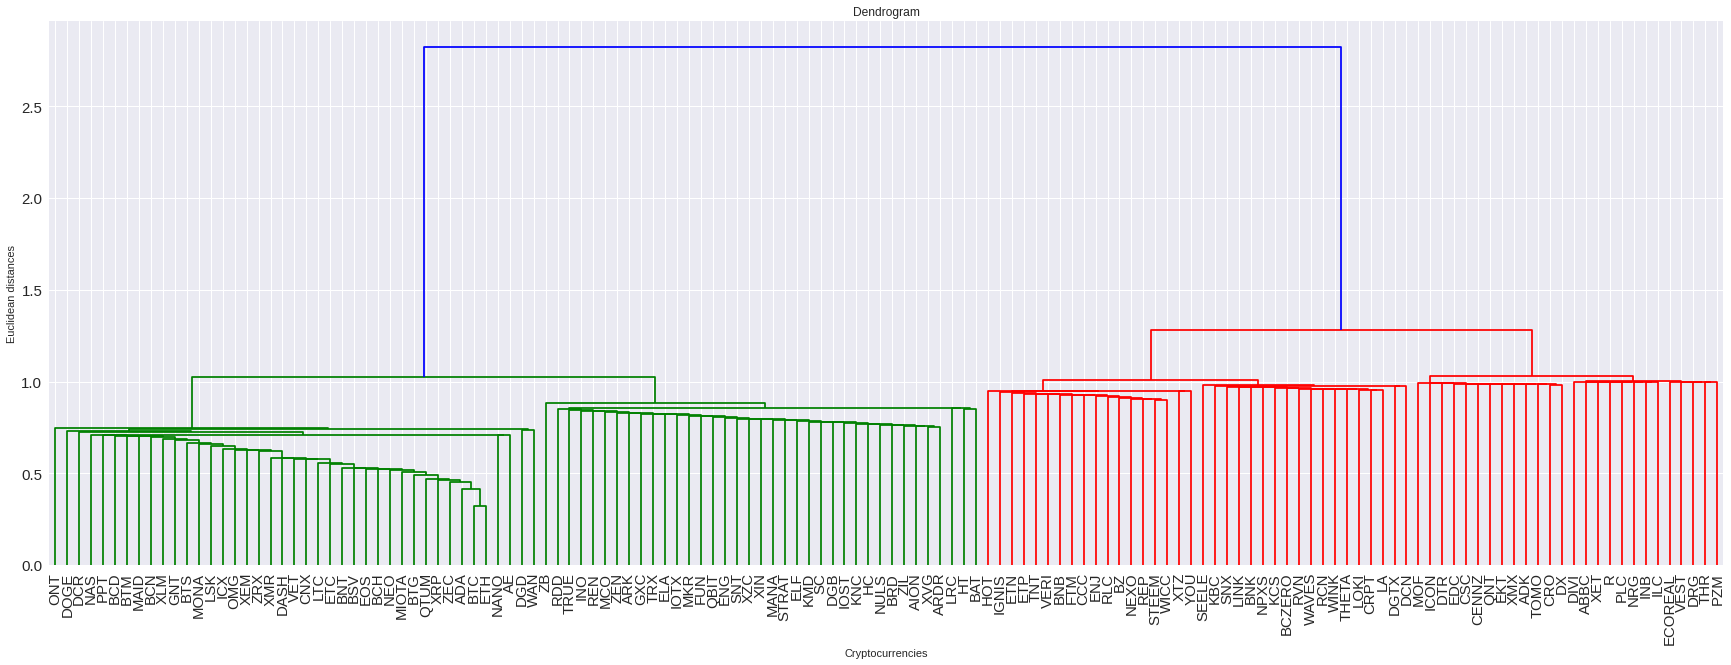

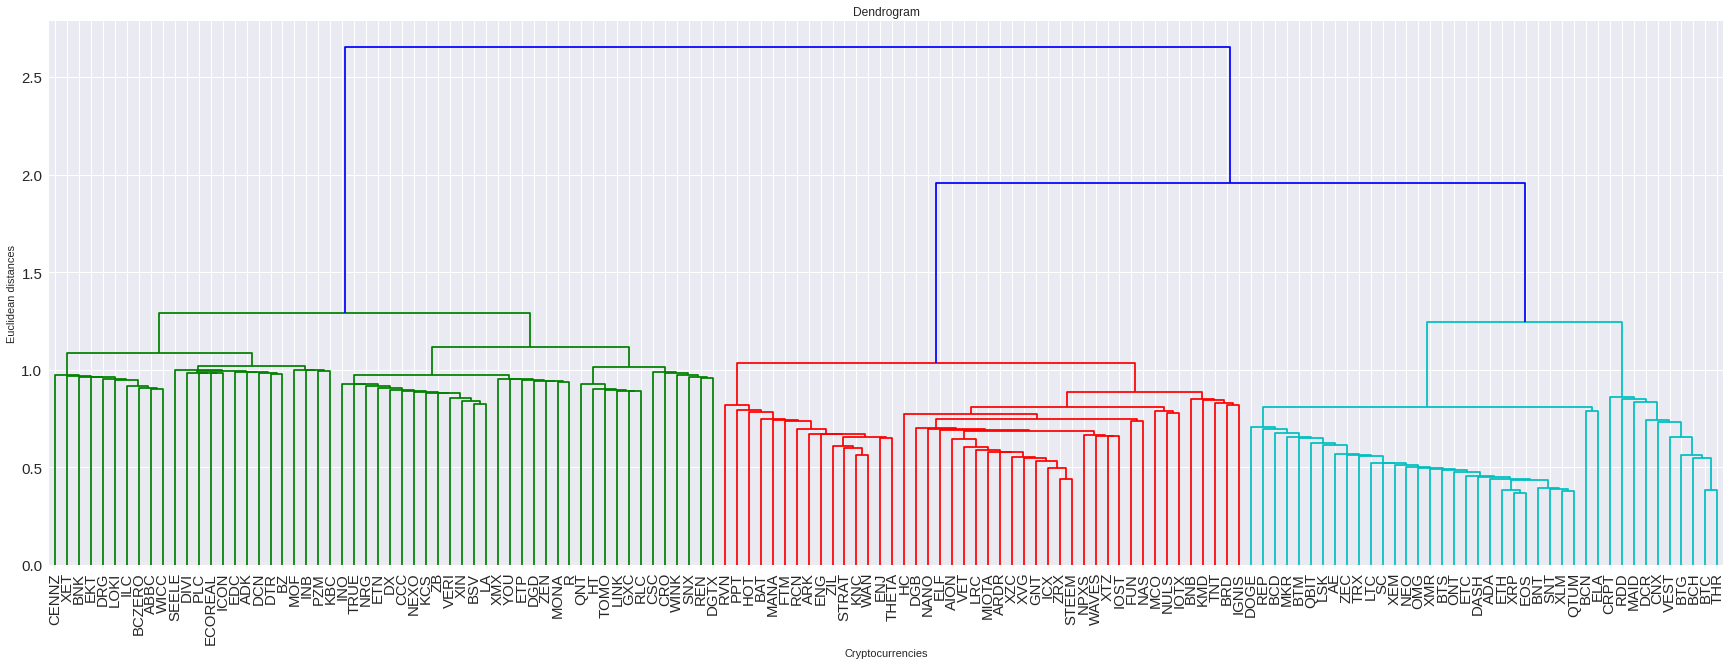

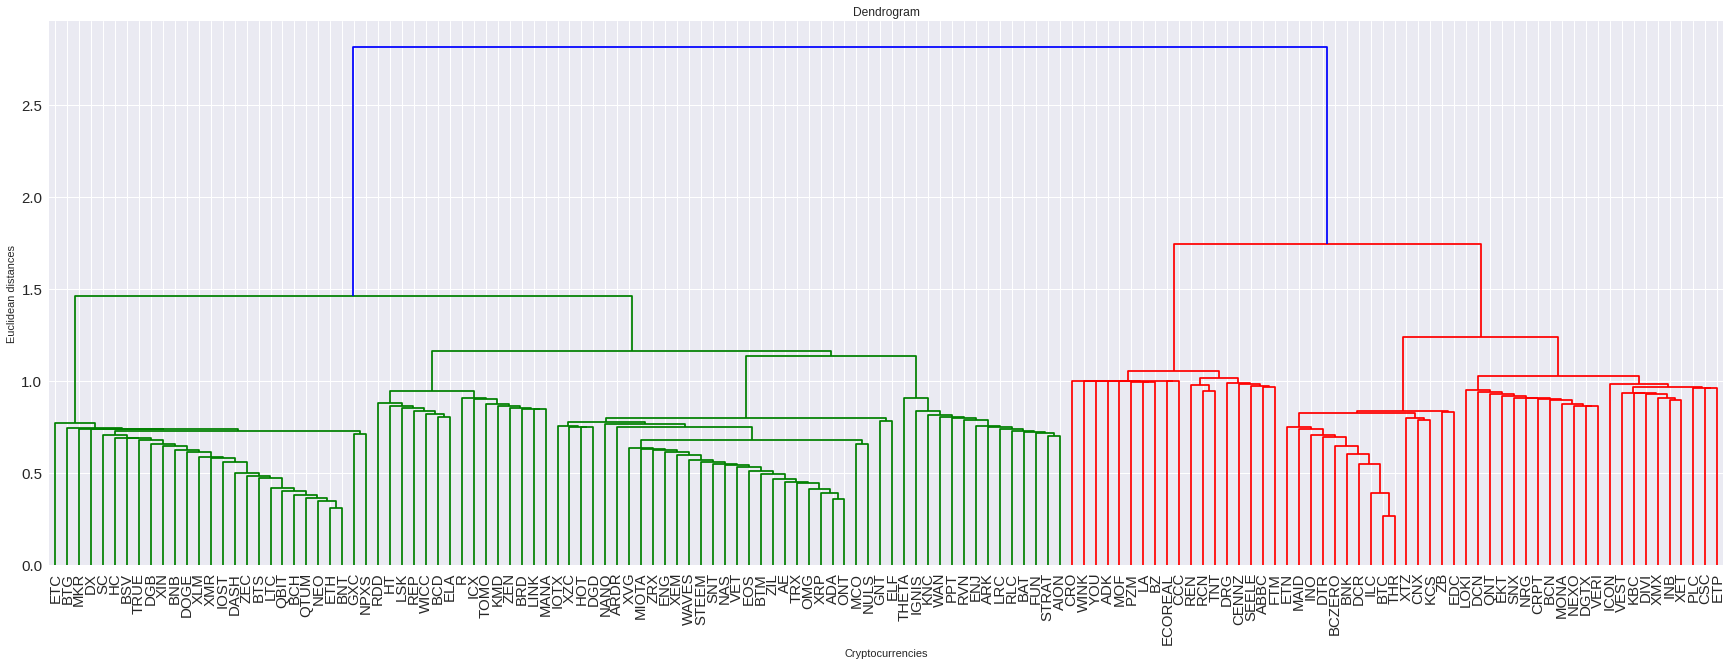

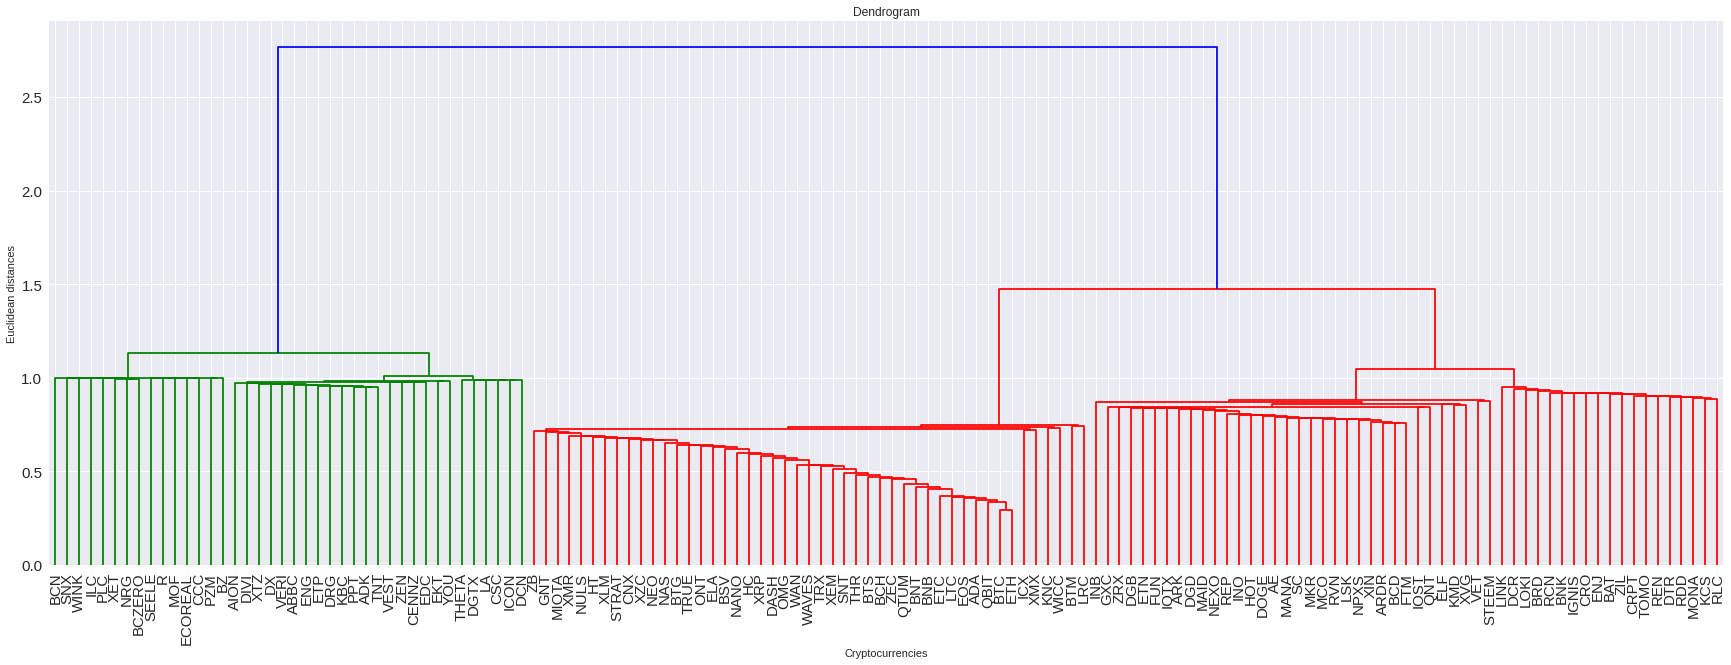

In [93]:
size = 120      # 120 rows in a new data-frame
list_of_dfs = [returns.iloc[i:i+size,:] for i in range(0, len(returns),size-30) if i < len(returns)-30]

[l_d.shape for l_d in list_of_dfs]
dendo = 0
for l_d in list_of_dfs:
    ward_clustering(l_d, 30, tickers, dendo=dendo) 
    dendo +=1